In [2]:
from typing import Sequence, Union
import os
import sys
import glob
import itertools
from datetime import datetime
from pprint import pprint
from tqdm import tqdm
import joblib

import numpy as np
import pandas as pd
import xarray as xr
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cmocean as cmo
from fusion import cmap

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.nn.functional as F
import torch.distributions
import pytorch_lightning as pl

import src
from src.attrs import PATHS, GLOBALS
from src import utils

from src.data import loading
from src.train import datasets, losses
from src.models import base, koopman_autoencoder, cnn
from src.tools import plot

/glade/u/home/abrettin/.conda/envs/causality/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/glade/u/home/abrettin/.conda/envs/causality/lib/python3.11/site-packages/torch/cuda/__init__.py:611: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [3]:
plt.style.use('custom.mplstyle')

In [4]:
areas = xr.open_dataarray(os.path.join(PATHS['grid'], 'areas.nc'))

# Make good plot

---

In [5]:
SUBPROJECT = 'cnn_pacific_daily_subsampled'
D = 20

metrics_path = os.path.join(PATHS[SUBPROJECT], 'forecast_metrics')

mse_clim_pac = xr.open_dataarray(os.path.join(metrics_path, f'clim_sample_mse.nc')).sel(variable='SSH')
mse_dp_pac = xr.open_dataarray(os.path.join(metrics_path, f'dp_pca_ssh_d{D}_best_sample_mse.nc'))
mse_lim_pac = xr.open_dataarray(os.path.join(metrics_path, f'lim_pca_ssh_d{D}_best_sample_mse.nc'))
mse_koopman_pac = xr.open_dataarray(os.path.join(metrics_path, f'kae_ssh_d{D}_sample_mse.nc'))


# Skill scores
SS_koopman_pac = (1 - mse_koopman_pac / mse_clim_pac).sel(variable='SSH')
SS_dp_pac = (1 - mse_dp_pac / mse_clim_pac).sel(variable='SSH')
SS_lim_pac  = (1 - mse_lim_pac / mse_clim_pac).sel(variable='SSH')

SS_koopman_dp_pac = (1 - mse_koopman_pac / mse_dp_pac).sel(variable='SSH')
SS_lim_dp_pac = (1 - mse_lim_pac / mse_dp_pac).sel(variable='SSH')
SS_koopman_lim_pac = (1 - mse_koopman_pac / mse_lim_pac).sel(variable='SSH')

In [6]:
SUBPROJECT = 'cnn_north_atlantic_daily_subsampled'
D = 20

metrics_path = os.path.join(PATHS[SUBPROJECT], 'forecast_metrics')

mse_clim_atl = xr.open_dataarray(os.path.join(metrics_path, f'clim_ssh_sample_mse.nc'))
mse_dp_atl = xr.open_dataarray(os.path.join(metrics_path, f'dp_pca_ssh_d{D}_best_sample_mse.nc'))
mse_lim_atl = xr.open_dataarray(os.path.join(metrics_path, f'lim_pca_ssh_d{D}_best_sample_mse.nc'))
mse_koopman_atl = xr.open_dataarray(os.path.join(metrics_path, f'kae_ssh_d{D}_sample_mse.nc'))


# Skill scores
SS_koopman_atl = (1 - mse_koopman_atl / mse_clim_atl).sel(variable='SSH')
SS_dp_atl = (1 - mse_dp_atl / mse_clim_atl).sel(variable='SSH')
SS_lim_atl  = (1 - mse_lim_atl / mse_clim_atl).sel(variable='SSH')

SS_koopman_dp_atl = (1 - mse_koopman_atl / mse_dp_atl).sel(variable='SSH')
SS_lim_dp_atl = (1 - mse_lim_atl / mse_dp_atl).sel(variable='SSH')
SS_koopman_lim_atl = (1 - mse_koopman_atl / mse_lim_atl).sel(variable='SSH')

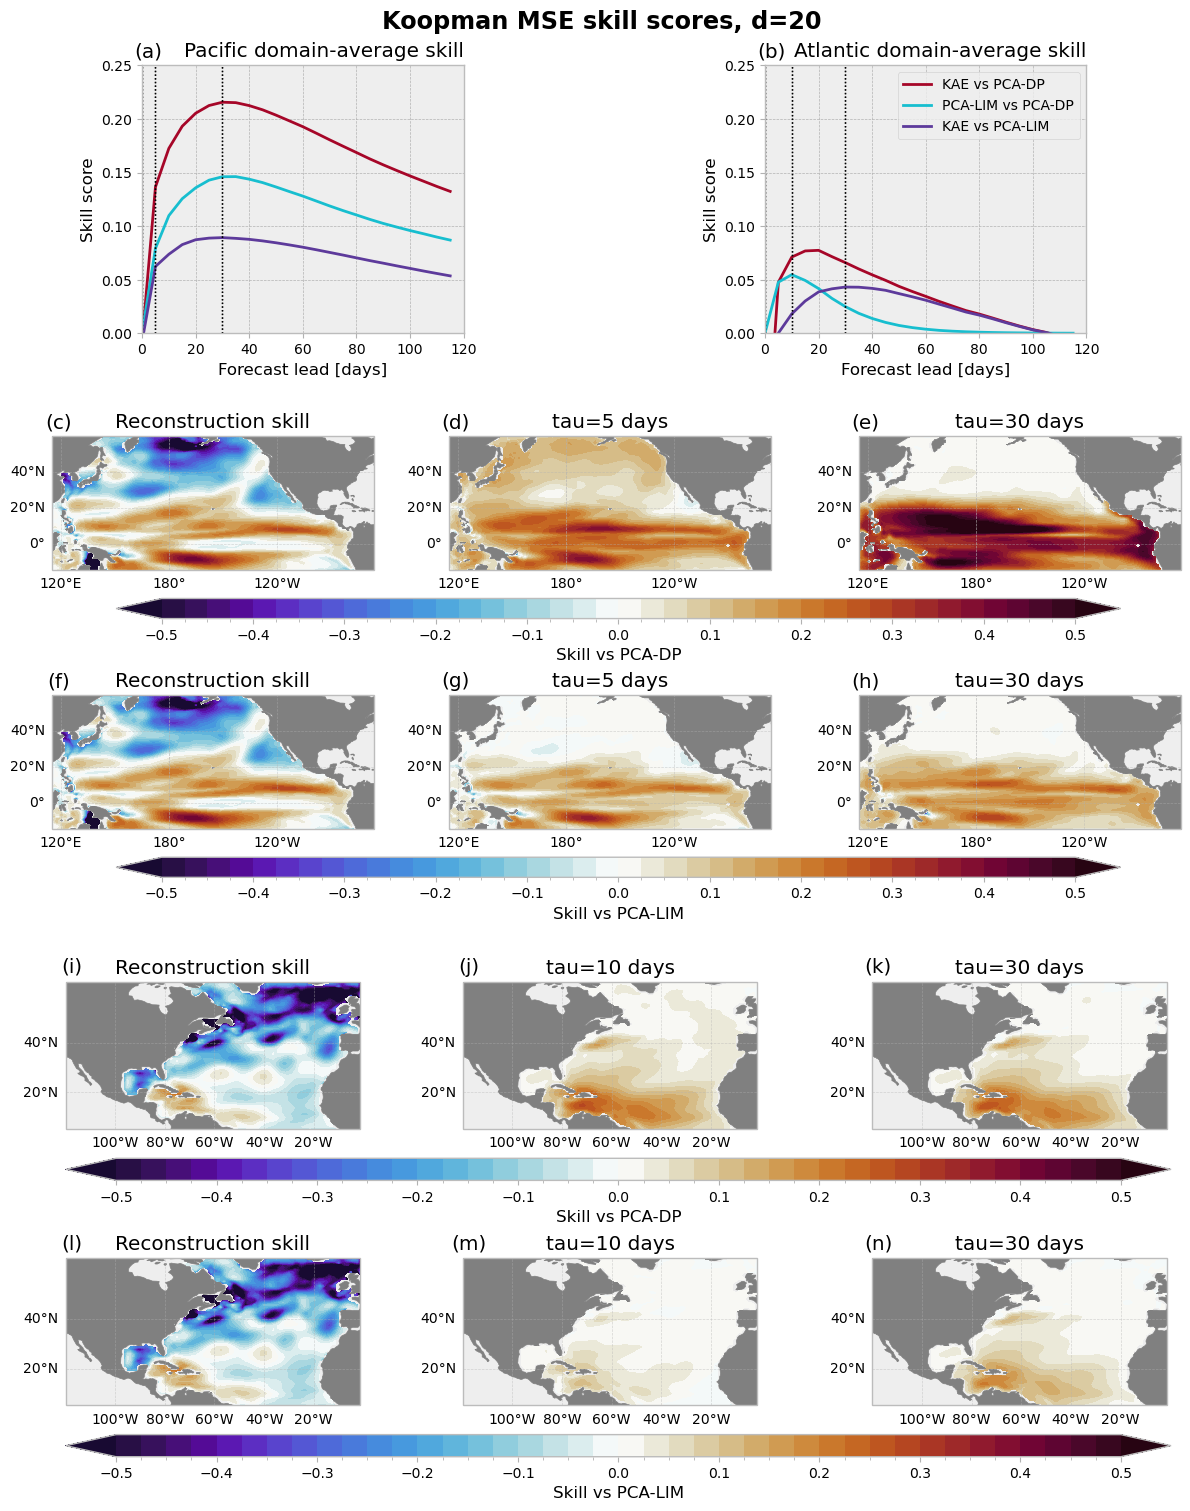

In [15]:
per_subplot_kw = {}
for label in list('cdefgh'):
    per_subplot_kw[label] = {'projection': ccrs.PlateCarree(central_longitude=200)}
for label in list('ijklmn'):
    per_subplot_kw[label] = {'projection': ccrs.PlateCarree(central_longitude=280)}

fig, axes = plt.subplot_mosaic(
    [
        list('aaabbb'),
        list('111111'),
        list('ccddee'),
        list('ffgghh'),
        list('222222'),
        list('iijjkk'),
        list('llmmnn')
    ],
    figsize=(12, 15),
    width_ratios=[1]*6,
    height_ratios=[2, 0.2, 1, 1, 0.2, 1.1, 1.1],
    per_subplot_kw=per_subplot_kw,
    layout='constrained'
)
fig.delaxes(axes['1'])
fig.delaxes(axes['2'])

#######################################################################################
lags_pac = {'c': 0, 'd': 5, 'e': 30, 'f': 0, 'g': 5, 'h': 30}

# Plotting for Pacific
# Domain averaged skill scores
SS_koopman_dp_pac.weighted(areas).mean(dim=('lat', 'lon')).plot(ax=axes['a'], color='C1')
SS_lim_dp_pac.weighted(areas).mean(dim=('lat', 'lon')).plot(ax=axes['a'], color='tab:cyan')
SS_koopman_lim_pac.weighted(areas).mean(dim=('lat', 'lon')).plot(ax=axes['a'], color='C2')
axes['a'].set_aspect(400)

axes['a'].vlines(lags_pac.values(), 0, 0.25, lw=1, ls=':', color='k')


axes['a'].set(
    title='',
    xlabel='Forecast lead [days]',
    ylabel='Skill score',
    xlim=(0, 120),
    ylim=(0, 0.25)
)
axes['a'].set_title('Pacific domain-average skill', loc='right')

# Maps of KAE relative to DP
map_kwargs = dict(
    levels=np.linspace(-0.5, 0.5, 41),
    cmap=cmap.reversed(), 
    extend='both',
    add_colorbar=False, 
    transform=ccrs.PlateCarree()
)
for key in list('cde'):
    lag = lags_pac[key]
    cax = SS_koopman_dp_pac.sel(lag=lag).plot.contourf(ax=axes[key], **map_kwargs)
    gl = axes[key].gridlines(ylocs=[0, 20, 40], lw=0.5, alpha=0.5)
    gl.bottom_labels = True
    gl.left_labels = True
    axes[key].add_feature(cartopy.feature.LAND, color=(0.5,0.5,0.5))
    axes[key].set(title=f'tau={lags_pac[key]} days')

cb = fig.colorbar(
    mappable=cax, 
    ax=[axes['c'], axes['d'], axes['e']],
    orientation='horizontal',
    label='Skill vs PCA-DP',
    # pad=-0.3,
    aspect=50,
    extend='neither'
)
cb.set_ticks(np.linspace(-0.5, 0.5, 11))

# Maps of KAE relative to LIM
map_kwargs = dict(
    levels=np.linspace(-0.5, 0.5, 41),
    cmap=cmap.reversed(),
    extend='both',
    add_colorbar=False, 
    transform=ccrs.PlateCarree()
)
for key in list('fgh'):
    lag = lags_pac[key]
    cax = SS_koopman_lim_pac.sel(lag=lag).plot.contourf(ax=axes[key], **map_kwargs)
    gl = axes[key].gridlines(ylocs=[0, 20, 40], lw=0.5, alpha=0.5)
    gl.bottom_labels = True
    gl.left_labels = True
    axes[key].add_feature(cartopy.feature.LAND, color=(0.5,0.5,0.5))
    axes[key].set(title=f'tau={lags_pac[key]} days')

cb = fig.colorbar(
    mappable=cax, 
    ax=[axes['f'], axes['g'], axes['h']],
    orientation='horizontal',
    label='Skill vs PCA-LIM',
    aspect=50,
    extend='neither'
)
cb.set_ticks(np.linspace(-0.5, 0.5, 11))

#######################################################################################
lags_atl = {'i': 0, 'j': 10, 'k': 30, 'l': 0, 'm': 10, 'n': 30}

# Plotting for Atlantic
# Domain averaged skill scores
SS_koopman_dp_atl.weighted(areas).mean(dim=('lat', 'lon')).plot(ax=axes['b'], color='C1', label='KAE vs PCA-DP')
SS_lim_dp_atl.weighted(areas).mean(dim=('lat', 'lon')).plot(ax=axes['b'], color='tab:cyan', label='PCA-LIM vs PCA-DP')
SS_koopman_lim_atl.weighted(areas).mean(dim=('lat', 'lon')).plot(ax=axes['b'], color='C2', label='KAE vs PCA-LIM')

axes['b'].set_aspect(400)
axes['b'].vlines(lags_atl.values(), 0, 0.25, lw=1, ls=':', color='k')

axes['b'].set(
    title='',
    xlabel='Forecast lead [days]',
    ylabel='Skill score',
    xlim=(0, 120),
    ylim=(0, 0.25)
)
axes['b'].set_title('Atlantic domain-average skill', loc='right')
axes['b'].legend(loc='upper right')

# Maps of KAE relative to DP
map_kwargs = dict(
    levels=np.linspace(-0.5, 0.5, 41),
    cmap=cmap.reversed(), 
    extend='both',
    add_colorbar=False, 
    transform=ccrs.PlateCarree()
)
for key in list('ijk'):
    lag = lags_atl[key]
    cax = SS_koopman_dp_atl.sel(lag=lag).plot.contourf(ax=axes[key], **map_kwargs)
    gl = axes[key].gridlines(ylocs=[0, 20, 40], lw=0.5, alpha=0.5)
    gl.bottom_labels = True
    gl.left_labels = True
    axes[key].add_feature(cartopy.feature.LAND, color=(0.5,0.5,0.5))
    axes[key].set(title=f'tau={lags_atl[key]} days')

cb = fig.colorbar(
    mappable=cax, 
    ax=[axes['i'], axes['j'], axes['k']],
    orientation='horizontal',
    label='Skill vs PCA-DP',
    # pad=-0.3,
    aspect=50,
    extend='neither'
)
cb.set_ticks(np.linspace(-0.5, 0.5, 11))

# Maps of KAE relative to LIM
map_kwargs = dict(
    levels=np.linspace(-0.5, 0.5, 41),
    cmap=cmap.reversed(),
    extend='both',
    add_colorbar=False, 
    transform=ccrs.PlateCarree()
)
for key in list('lmn'):
    lag = lags_atl[key]
    cax = SS_koopman_lim_atl.sel(lag=lag).plot.contourf(ax=axes[key], **map_kwargs)
    gl = axes[key].gridlines(ylocs=[0, 20, 40], lw=0.5, alpha=0.5)
    gl.bottom_labels = True
    gl.left_labels = True
    axes[key].add_feature(cartopy.feature.LAND, color=(0.5,0.5,0.5))
    axes[key].set(title=f'tau={lags_atl[key]} days')

cb = fig.colorbar(
    mappable=cax, 
    ax=[axes['l'], axes['m'], axes['n']],
    orientation='horizontal',
    label='Skill vs PCA-LIM',
    aspect=50,
    extend='neither'
)
cb.set_ticks(np.linspace(-0.5, 0.5, 11))

#######################################################################################
for key in list('cfil'):
    axes[key].set(title='Reconstruction skill')

for key, ax in axes.items():
    if key in ['a', 'b']:
        xy = (0.02, 1.05)
    else:
        xy = (0.02, 1.1)
    ax.annotate(f'({key})', xy=xy, xycoords='axes fraction', ha='center', va='center', fontsize='x-large')

fig.suptitle(f"Koopman MSE skill scores, d={D}")
fig.savefig(
    os.path.join(PATHS['visualization'], 'Figures', 'ssh_only_skill_scores.pdf'),
    bbox_inches='tight'
)